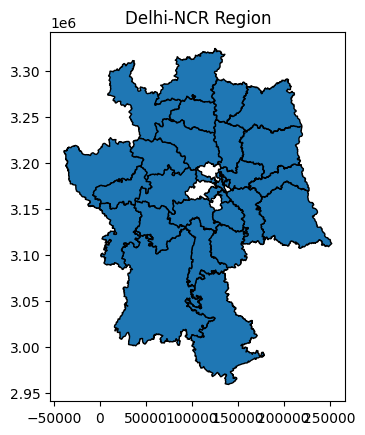

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Delhi-NCR GeoJSON    
ncr = gpd.read_file("/Users/shreyshah/Documents/earth-observation-delhi-air/data/delhi_ncr_region.geojson")
ncr = ncr.to_crs(epsg=32644)  # Convert to UTM for metric-based gridding

ncr.plot(edgecolor='black')
plt.title("Delhi-NCR Region")
plt.show()

from shapely.geometry import box
import numpy as np

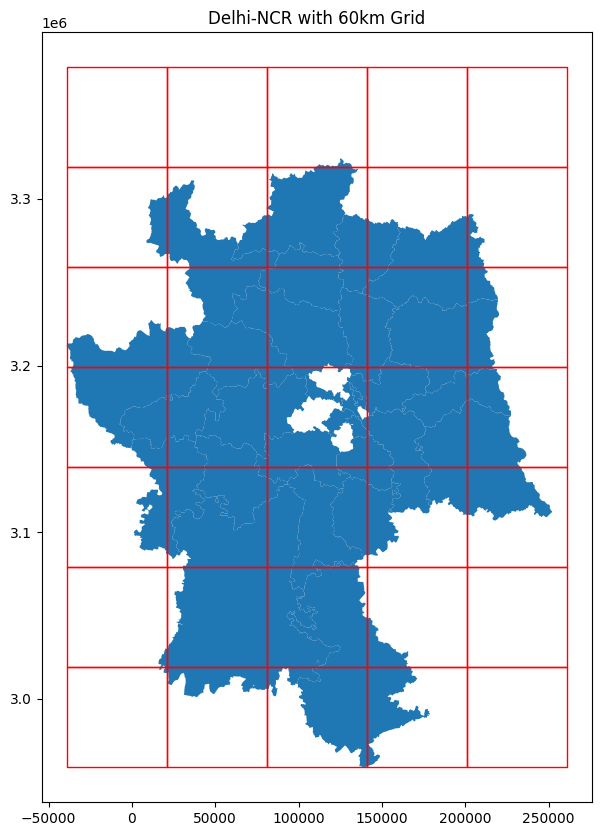

In [8]:
from shapely.geometry import box
import numpy as np

def create_grid(gdf, grid_size):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    cols = list(np.arange(xmin, xmax, grid_size))
    rows = list(np.arange(ymin, ymax, grid_size))
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append(box(x, y, x+grid_size, y+grid_size))
    grid = gpd.GeoDataFrame({"geometry": polygons}, crs=gdf.crs)
    return grid

grid = create_grid(ncr, 60000)
ax = ncr.plot(figsize=(10,10))
grid.plot(ax=ax, facecolor="none", edgecolor='red')
plt.title("Delhi-NCR with 60km Grid")
plt.show()

In [ ]:
pip install leafmap # Used Leafmap for interactive map visualization and not geemap because it requires signup for Google Earth Engine.

  Obtaining dependency information for leafmap from https://files.pythonhosted.org/packages/0c/a2/a55907315034bc95a10671e36a647c3b0dd3f80a8e70ded57928f2bcac01/leafmap-0.48.6-py2.py3-none-any.whl.metadata
  Obtaining dependency information for anywidget from https://files.pythonhosted.org/packages/2b/f0/09a30ca0551af20c7cefa7464b7ccb6f5407a550b83c4dcb15c410814849/anywidget-0.9.18-py3-none-any.whl.metadata
  Obtaining dependency information for duckdb from https://files.pythonhosted.org/packages/37/30/56cc16f223e080edb5aa5aca8d1e3dc7710ecff3726ba2d7354ae1a40223/duckdb-1.3.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for geojson from https://files.pythonhosted.org/packages/18/67/a7fa2d650602731c90e0a86279841b4586e14228199e8c09165ba4863e29/geojson-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for ipyvuetify from https://files.pythonhosted.org/packages/47/4d/fd1a6a888f8abb6b8dc316cc78b5153e75eff7ae66a94cf30b144fadd09d/ipyvuetify-1.11.3

In [25]:
%pip install leafmap

import leafmap.foliumap as leafmap

m = leafmap.Map(center=[28.6139, 77.2090], zoom=8)
m.add_basemap("SATELLITE")
m.add_gdf(grid, layer_name="Grid")
m

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from shapely.geometry import Point

def extract_points(grid):
    centers = grid.geometry.centroid
    corners = []
    for geom in grid.geometry:
        coords = list(geom.exterior.coords)[:4]  # First 4 corners only
        for c in coords:
            corners.append(Point(c))
    all_points = list(centers) + corners
    return gpd.GeoDataFrame(geometry=all_points, crs=grid.crs)

points_gdf = extract_points(grid)
m.add_gdf(points_gdf, layer_name="Grid Points", style={'color': 'blue', 'radius': 3})
m

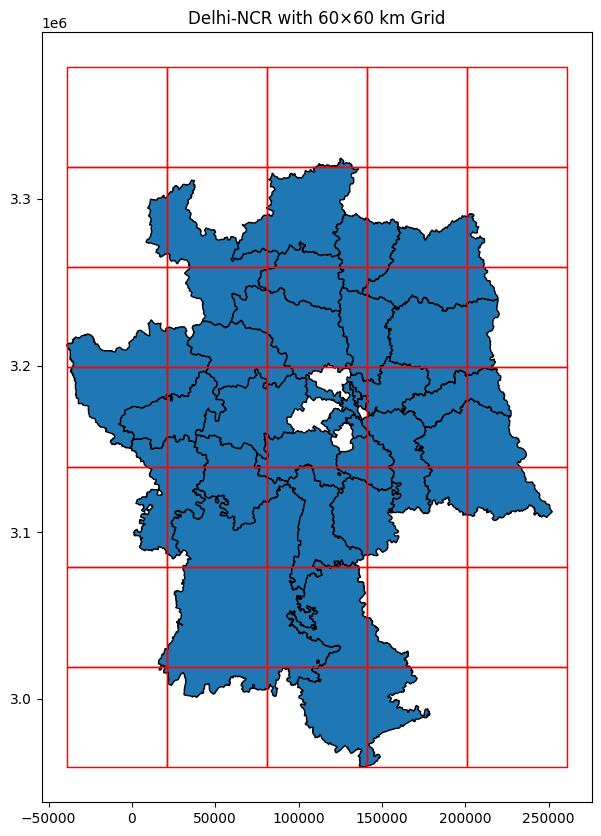

Total images before filtering: 9216
Total images after filtering: 9216


In [1]:
# Required Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import box, Point
import leafmap.foliumap as leafmap

# Load the Delhi-NCR GeoJSON
ncr = gpd.read_file("/Users/shreyshah/Documents/earth-observation-delhi-air/data/delhi_ncr_region.geojson")
ncr = ncr.to_crs(epsg=32644)  # Use UTM CRS for metric-based grid

# === 1. Plot Delhi-NCR with 60×60 km grid ===
def create_grid(gdf, grid_size):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    cols = np.arange(xmin, xmax, grid_size)
    rows = np.arange(ymin, ymax, grid_size)
    polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
    return gpd.GeoDataFrame({'geometry': polygons}, crs=gdf.crs)

grid = create_grid(ncr, 60000)  # 60x60 km grid

# Plot using matplotlib
ax = ncr.plot(figsize=(10, 10), edgecolor='black')
grid.plot(ax=ax, facecolor="none", edgecolor='red')
plt.title("Delhi-NCR with 60×60 km Grid")
plt.show()


# === 2. Overlay on Satellite Basemap ===
m = leafmap.Map(center=[28.6139, 77.2090], zoom=8)
m.add_basemap("SATELLITE")
m.add_gdf(grid, layer_name="Grid")


# === 3. Mark Four Corners and Center of Each Grid Cell ===
def extract_grid_points(grid_gdf):
    centers = grid_gdf.geometry.centroid
    corners = []
    for geom in grid_gdf.geometry:
        coords = list(geom.exterior.coords)[:4]  # first 4 corners
        for x, y in coords:
            corners.append(Point(x, y))
    all_points = list(centers) + corners
    return gpd.GeoDataFrame(geometry=all_points, crs=grid_gdf.crs)

points_gdf = extract_grid_points(grid)
m.add_gdf(points_gdf, layer_name="Grid Points", style={'color': 'blue', 'radius': 3})
m  # Display the map with grid + corners + centers


# === 4. Filter Images Based on Whether Their Center Coordinates Fall Within the Grid ===

# CASE 1: If you have image_coords.csv (from pipeline or metadata)
try:
    df_images = pd.read_csv("image_coords.csv")  # Should contain 'lat', 'lon', 'filename'
    df_images["geometry"] = df_images.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf_images = gpd.GeoDataFrame(df_images, geometry="geometry", crs="EPSG:4326")
    gdf_images = gdf_images.to_crs(grid.crs)
except:
    # CASE 2: If you don’t have CSV but only .png images with coords as filenames like '28.70_77.10.png'
    import os
    image_dir = "/Users/shreyshah/Documents/earth-observation-delhi-air/data/rgb"
    png_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    coords = []
    for f in png_files:
        name = f.replace('.png', '')
        try:
            lat, lon = map(float, name.split('_'))
            coords.append({'lat': lat, 'lon': lon, 'filename': f})
        except:
            print(f"Skipping invalid filename: {f}")
    df_images = pd.DataFrame(coords)
    df_images["geometry"] = df_images.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf_images = gpd.GeoDataFrame(df_images, geometry="geometry", crs="EPSG:4326")
    gdf_images = gdf_images.to_crs(grid.crs)

# Spatial join to filter
filtered_images = gpd.sjoin(gdf_images, grid, predicate='within', how='inner')
valid_images = filtered_images['filename'].tolist()

# === 5. Count and Report Images Before and After Filtering ===
print(f"Total images before filtering: {len(df_images)}")
print(f"Total images after filtering: {len(filtered_images)}")
